In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import Progbar
from transformers import AutoTokenizer
from tensorflow.keras import backend as K
from keras_nlp.layers import TransformerEncoder, TransformerDecoder

import numpy as np
import requests
import io
import pandas as pd
import string
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # Change this value as per requirement
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2024-02-19 06:01:01.431907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 06:01:01.432020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 06:01:01.596430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [3]:
image_shape = (100, 100, 3)


def download_image_buffer(url):
    img = None
    try:
        data = requests.get(url,headers={"user-agent": "I am a valid user, please give me image"}).content
        img = Image.open(io.BytesIO(data))
        img = img.resize(image_shape[:2])
        img = np.array(img, dtype=np.float64)/255
    except:
        pass
    
    return img


def load_img(path, shape):
    img = keras.utils.load_img(path, color_mode="rgb")
    img = img.resize(shape)
    return np.array(img, dtype=np.float64)/255


learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
image_size = 100 
patch_size = 5 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
sequence_length = 128
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size

In [5]:
def dict_map(img, tokenized_text):
    return ({
        "image": img,
        "text": tokenized_text[:-1]
    }, tokenized_text[1:])

### load conceptual-12m dataset

In [ ]:
# image_files = os.listdir("./datasets/conceptual-12m/images")
# image_idx = [int(item.split(".")[0]) for item in tqdm(image_files)]
# image_idx[:5]

# with open("./datasets/conceptual-12m/cc12m.tsv", "r", encoding="utf-8") as dataset_file:    
#     urls, texts = [], []

#     file_idx = 0

#     for item in tqdm(dataset_file):
#         url, text = item.split("\t")

#         texts.append(text)

# captions = [texts[i] for i in image_idx]

# del texts, urls

# captions[:5]

# image_files = np.array(image_files, dtype=str)
# captions = np.array(captions, dtype=str)

# base_dir = "./datasets/conceptual-12m/images/"

In [ ]:
# def preprocess(path, text):
#     path = path.numpy().decode('utf-8')
#     text = text.numpy().decode('utf-8')

#     img = load_img(base_dir + path, image_shape[:2])
#     tokenized_text = np.array(tokenizer.encode(text, max_length=sequence_length, add_special_tokens=True, padding="max_length", truncation=True))

#     return img, tokenized_text


In [ ]:
# batch_size = 32

# dataset = (tf.data.Dataset.from_tensor_slices((image_files, captions))
#            .shuffle(1000)
#            .map(lambda filepath, caption: tf.py_function(preprocess, [filepath, caption], [tf.float64, tf.int32]))
#            .map(dict_map)
#            .batch(batch_size)
#            .prefetch(tf.data.AUTOTUNE))

### load flick-30k dataset

In [6]:
def convert_to_int(item):
    try:
        return int(item)
    except:
        return -1

In [7]:
base_dir = "./datasets/flickr30k_images/flickr30k_images/"

captions_df = pd.read_csv("./datasets/flickr30k_images/results.csv", delimiter='|')
captions_df = captions_df[captions_df[' comment_number'].apply(convert_to_int) == 0]

image_files = captions_df['image_name'].to_numpy()
captions = captions_df[' comment'].to_numpy()

del captions_df

image_files.shape

(31783,)

In [8]:
def preprocess(path, text):
    path = path.numpy().decode('utf-8')
    text = text.numpy().decode('utf-8')

    img = load_img(base_dir + path, image_shape[:2])
    tokenized_text = np.array(tokenizer.encode(text, max_length=sequence_length, add_special_tokens=True, padding="max_length", truncation=True), dtype=np.int32)

    return img, tokenized_text


In [9]:
batch_size = 40

split = 0.99
DATASET_SIZE = len(image_files)
split_idx = int(split * DATASET_SIZE)

train_files, test_files = image_files[:-960], image_files[-960:]
train_captions, test_captions = captions[:-960], captions[-960:]
print(train_files.shape, test_files.shape)
train_dataset = (tf.data.Dataset.from_tensor_slices((train_files, train_captions))
           .shuffle(1000)
           .map(lambda filepath, caption: tf.py_function(preprocess, [filepath, caption], [tf.float64, tf.int32]))
           .map(dict_map)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

validation_dataset = (tf.data.Dataset.from_tensor_slices((test_files, test_captions))
           .shuffle(1000)
           .map(lambda filepath, caption: tf.py_function(preprocess, [filepath, caption], [tf.float64, tf.int32]))
           .map(dict_map)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

(30823,) (960,)


### Modeling

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        self._input = images
        batch_size = tf.shape(images)[0]
        patches_tensor = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches_tensor.shape[-1]  # Dimension of each patch

        patches_tensor = tf.reshape(patches_tensor, [batch_size, self.num_patches, patch_dims])
        return patches_tensor

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        self._input = inputs
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [11]:
class EncoderBlock(layers.Layer):
    def __init__(self, 
                 num_heads, 
                 embedding_dims, 
                 hidden_layers, 
                 hidden_units="same", 
                 attn_dropout=0.2, 
                 ff_dropout=0.2, 
                 epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)

        self.num_heads = num_heads
        self.embedding_dims = embedding_dims
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units if hidden_units != "same" else embedding_dims
        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=attn_dropout
        )
        self.attn_norm = layers.LayerNormalization(epsilon=epsilon)
        self.ff = []

        for _ in range(hidden_layers):
            self.ff.append(layers.Dense(
                self.hidden_units,
                activation=tf.nn.gelu
            ))
            self.ff.append(layers.Dropout(ff_dropout))

        self.ff = keras.Sequential(self.ff)
        self.ff_norm = layers.LayerNormalization()
    
    def call(self, inputs, mask=None):
        attn_output, attn_score = self.attn(
            query=inputs,
            key=inputs,
            value=inputs,
            attention_mask=mask,
            return_attention_scores=True
        )

        attn_output_norm = self.attn_norm(inputs + attn_output)

        x = self.ff(attn_output_norm)
        
        ff_output = self.ff_norm(attn_output + x)

        self.attn_score = attn_score
        
        return {
            "ff_output": ff_output,
            "attn_output": attn_score
        }

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embedding_dim": self.embedding_dims,
                "num_heads": self.num_heads,
                "ff_hidden_layers": self.hidden_layers,
                "ff_hidden_units": self.hidden_units
            }
        )
        return config

In [12]:
class DecoderBlock(layers.Layer):
    def __init__(self, 
                 num_heads_self, 
                 embedding_dims_self, 
                 hidden_layers, 
                 hidden_units="same", 
                 num_heads_cross="same", 
                 embedding_dims_cross="same", 
                 attn_dropout=0.2, 
                 ff_dropout=0.2, 
                 epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)

        self.num_heads = num_heads
        self.embedding_dims = embedding_dims_self
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units if hidden_units != "same" else embedding_dims_self
        self.num_heads_cross = num_heads_cross if num_heads_cross != "same" else num_heads_self
        self.embedding_dims_cross = embedding_dims_cross if embedding_dims_cross != "same" else embedding_dims_self

        self.self_attn = layers.MultiHeadAttention(
            num_heads=num_heads_self, 
            key_dim=embedding_dims_self,
            dropout=attn_dropout,
            name="Self-attn-decoder"
        )
        self.self_norm = layers.LayerNormalization(epsilon=epsilon)

        self.cross_attn = layers.MultiHeadAttention(
            num_heads=self.num_heads_cross, 
            key_dim=self.embedding_dims_cross,
            dropout=attn_dropout,
            name="cross-attn-decoder"
        )
        self.cross_norm = layers.LayerNormalization()
        
        self.ff = []

        for _ in range(hidden_layers):
            self.ff.append(layers.Dense(
                self.hidden_units,
                activation=tf.nn.gelu
            ))
            self.ff.append(layers.Dropout(ff_dropout))

        self.ff = keras.Sequential(self.ff)
        self.ff_norm = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        self_attn_output = self.self_attn(
            query=inputs, 
            key=inputs, 
            value=inputs, 
            use_causal_mask=True, 
            # attention_mask=mask
        )
        self_attn_output = self.self_norm(self.add([inputs, self_attn_output]))

        cross_attn_output = self.cross_attn(
            query=self_attn_output, 
            key=encoder_outputs, 
            value=encoder_outputs,
            use_causal_mask=True
        )
        cross_attn_output = self.cross_norm(self.add([self_attn_output, cross_attn_output]))

        ff_output = self.ff(cross_attn_output)
        ff_output = self.ff_norm(self.add([ff_output, cross_attn_output]))

        return ff_output
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embedding_dim": self.embedding_dims,
                "embedding_dim_cross": self.embedding_dims_cross,
                "num_heads": self.num_heads,
                "num_heads_cross": self.num_heads_cross,
                "ff_hidden_layers": self.hidden_layers,
                "ff_hidden_units": self.hidden_units
            }
        )
        return config

In [13]:
num_blocks_encoder = 3
num_blocks_decoder = 3
num_heads = 16
embedding_dims = 128
hidden_layers = 2
projection_dim = 128
attn_dropout=0.4
ff_dropout=0.3

In [14]:
image_input = layers.Input(shape=image_shape, name="image")
patches = Patches(patch_size, num_patches, name="patches")(image_input)
encoded_patches = PatchEncoder(num_patches, projection_dim, name="patch_encoder")(patches)

# attention_mask = layers.Input(shape=(sequence_length-1), name="attention_mask")
caption_input = layers.Input(shape=(sequence_length-1), name="text")
encoded_captions = PositionalEmbedding(sequence_length, vocab_size, embedding_dims, name="caption_encoder")(caption_input)


for _ in range(num_blocks_encoder):
    encoded_patches = EncoderBlock(
        num_heads,
        embedding_dims,
        hidden_layers,
        epsilon=1e-3,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout
    )(encoded_patches)["ff_output"]


for _ in range(num_blocks_decoder):
    encoded_captions = DecoderBlock(
        num_heads,
        embedding_dims,
        hidden_layers,
        epsilon=1e-3,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout
    )(encoded_captions, encoded_patches)

top_layer = layers.Dense(1024, activation=tf.nn.gelu)(encoded_captions)
top_layer = layers.Dense(vocab_size)(top_layer)

test_model = Model(inputs=[image_input, caption_input], outputs=top_layer)

In [16]:
# consine_restart_schedule = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate = 0.001,first_decay_steps = 500,alpha=0.5)
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 1000,
    alpha=0.5,
    warmup_target=0.001,
    warmup_steps=100
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoints/",
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch'
)

test_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", 
             keras.metrics.SparseTopKCategoricalAccuracy(k=20, name="top_20_accuracy"), 
             keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top_10_accuracy"), 
             keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy")],
)
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 patches (Patches)           (None, 400, 75)              0         ['image[0][0]']               
                                                                                                  
 patch_encoder (PatchEncode  (None, 400, 128)             60928     ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 encoder_block (EncoderBloc  {'ff_output': (None, 400,    1088384   ['patch_encoder[0][0]']   

In [20]:
_callbacks = [checkpoint_callback]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=test_model)

logs = {}
callbacks.on_train_begin(logs=logs)

for i in range(num_epochs):
    train_dataset_iter = train_dataset.as_numpy_iterator()
    validation_dataset_iter = validation_dataset.as_numpy_iterator()

    callbacks.on_epoch_begin(i, logs=logs)
    train_progbar = Progbar(len(train_dataset))

    for step in range(len(train_dataset)):

        batch_input, target = train_dataset_iter.next()
        # callbacks.on_batch_begin(batch_input, logs=logs)

        result = test_model.train_on_batch(batch_input, y=target, return_dict=True)

        loss = result["loss"]
        accuracy = result['accuracy']

        logs = result

        train_progbar.update(step + 1, [("lr", test_model.optimizer.learning_rate)]+[(k, v) for k,v in result.items()])

    validation_progbar = Progbar(len(validation_dataset))

    for step in range(len(validation_dataset)):

        batch_input, target = validation_dataset_iter.next()

        validation_result = test_model.test_on_batch(batch_input, y=target, return_dict=True)

        validation_result = {f"val_{key}":value for key, value in validation_result.items()}
        logs.update(validation_result)

        validation_progbar.update(step + 1, [(k, v) for k,v in validation_result.items()])

    callbacks.on_epoch_end(i, logs=logs)
    
    exit_flag=False

    print()

    with open('training-signals.txt', 'r') as signal:
        exit_flag = next(signal) == "STOP"

    if exit_flag:
        with open('training-signals.txt', 'w') as signal:
            signal.writelines(['GO'])
        break

callbacks.on_train_end(logs=logs)


24/24 [==============================] - 14s 597ms/step - val_loss: 4.0250 - val_accuracy: 0.3566 - val_top_20_accuracy: 0.7286 - val_top_10_accuracy: 0.6553 - val_top_5_accuracy: 0.5746

24/24 [==============================] - 14s 597ms/step - val_loss: 4.0621 - val_accuracy: 0.3533 - val_top_20_accuracy: 0.7265 - val_top_10_accuracy: 0.6548 - val_top_5_accuracy: 0.5743

24/24 [==============================] - 14s 597ms/step - val_loss: 4.0902 - val_accuracy: 0.3556 - val_top_20_accuracy: 0.7272 - val_top_10_accuracy: 0.6556 - val_top_5_accuracy: 0.5756

24/24 [==============================] - 14s 600ms/step - val_loss: 4.1169 - val_accuracy: 0.3556 - val_top_20_accuracy: 0.7260 - val_top_10_accuracy: 0.6561 - val_top_5_accuracy: 0.5754

24/24 [==============================] - 14s 599ms/step - val_loss: 4.1277 - val_accuracy: 0.3511 - val_top_20_accuracy: 0.7241 - val_top_10_accuracy: 0.6522 - val_top_5_accuracy: 0.5732

24/24 [==============================] - 14s 599ms/step - va

In [18]:
test_model.save_weights("./model_weights/flickr-2.h5")

In [16]:
test_model.load_weights("./model_weights/flickr-2.h5")

In [ ]:
example, target = train_dataset.as_numpy_iterator().next()

In [ ]:
target

In [ ]:
output = test_model(example)

In [ ]:
loss=keras.losses.SparseCategoricalCrossentropy()

In [ ]:
with tf.device("/cpu:0"):
    print(loss(target, output))

# Sampling

In [17]:
from PIL import Image
from random import randint

import matplotlib.pyplot as plt

30394:  A young boy in a green shirt is strapped in a harness climbing a rock wall .


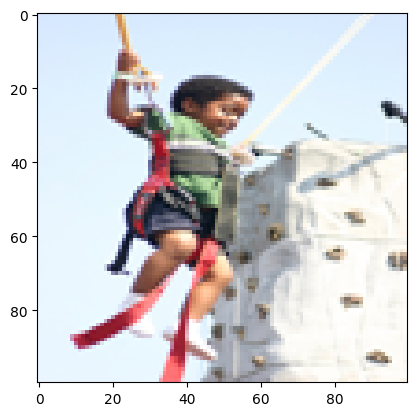

In [18]:
sample_idx = randint(0, len(train_files))
image = load_img(base_dir+train_files[sample_idx], (100, 100))
caption = train_captions[sample_idx]

print(f"{sample_idx}: {caption}")
plt.imshow(image)

#### Top k sampling

In [20]:
# Set layer activation for the last layer to be None so that we can scale top k sample after selecting the top k values
test_model.layers[-1].activation=None

In [21]:

def top_k_sample(top_k_logits, temperature=1.0):
    """
    Perform top-k sampling with temperature on the top-k logits.

    Parameters:
    - top_k_logits: A 1D numpy array representing the top-k logits.
    - temperature: A parameter controlling the level of randomness in sampling.

    Returns:
    - A sampled index.
    """

    # Apply temperature to the logits
    logits_with_temperature = top_k_logits / temperature

    # Compute softmax to get probabilities
    probabilities = np.exp(logits_with_temperature - np.max(logits_with_temperature))
    probabilities /= np.sum(probabilities)

    # Sample from the top-k probabilities
    sampled_index = np.random.choice(np.arange(len(top_k_logits)), p=probabilities)

    return sampled_index


In [29]:
target_ids = tokenizer.encode_plus(caption, max_length=sequence_length, add_special_tokens=True, padding="max_length", truncation=True, return_tensors='np')
target_ids = target_ids['input_ids']

initial_ids = tokenizer.encode_plus("[CLS]", max_length=sequence_length-1, add_special_tokens=False, padding="max_length", truncation=True, return_tensors='np')
initial_tokens = initial_ids['input_ids']
initial_mask = initial_ids['attention_mask']

#### Top k sampling

In [35]:
k = 500

sampled_ids = [initial_tokens[0][0]]

attention_scores = {
    4: [],
    6: []
}

# for i in tqdm(range(sequence_length-1), f"sampling for top {k}"):
for i in range(sequence_length-1):
    logits = test_model(dict(image=np.array([image]), text=np.array(initial_tokens)), mask=initial_mask)[0][i]

    for i in attention_scores.keys():
        attention_scores[i].append(test_model.layers[i].attn_score)

    top_k = tf.math.top_k(logits, k=k)

    top_k_logits = top_k.values.numpy()
    top_k_indices = top_k.indices.numpy()

    sample = top_k_sample(top_k_logits, temperature=1)
    sampled_id = top_k_indices[sample]

    sampled_ids.append(sampled_id)
    print(tokenizer.decode(sampled_ids), end='\r')
    try:
        initial_tokens[:, i+1] = sampled_id
    except:
        break

    if sampled_id == 102:
        break

#### Greedy sample

In [31]:
# Initialize the sampled_ids list with the initial tokens
sampled_ids = [initial_tokens[0][0]]

attention_scores = {
    4: [],
    6: []
}
# Loop through the sequence length - 1
for i in range(sequence_length-1):
    # Get the logits for the current position
    logits = test_model(dict(image=np.array([image]), text=np.array(initial_tokens)), mask=initial_mask)[0][i]
    for i in attention_scores.keys():
        attention_scores[i].append(test_model.layers[i].attn_score)
    # Get the index of the token with the highest probability (greedy search)
    sampled_id = tf.argmax(tf.math.softmax(logits), axis=-1).numpy()

    # Append the sampled token to the sampled_ids list
    sampled_ids.append(sampled_id)
    print(tokenizer.decode(sampled_ids), end='\r')

    # Update the initial_tokens with the sampled token for the next iteration
    try:
        initial_tokens[:, i+1] = sampled_id
    except:
        break

    # Break the loop if the end token is generated
    if sampled_id == 102:
        break


In [34]:
sampled_id

1998

In [36]:
tokenizer.decode(1998)

'and'

In [43]:
logits, idx = tf.math.top_k(logits, k=5)

In [46]:
logits/0.5

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-16.659878, -20.213518, -21.97677 , -22.419638, -25.719751],
      dtype=float32)>

<BarContainer object of 5 artists>

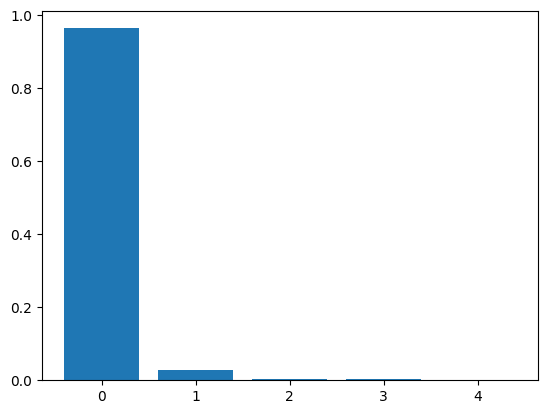

In [49]:
plt.bar(range(5), tf.math.softmax(logits/0.5))

In [40]:
tf.argmax(tf.math.softmax(logits), axis=-1).numpy()


1998

In [ ]:
test_model.layers[4].attn_score

In [ ]:
top_k_logits = top_k_logits/0.4
probs = tf.math.softmax(top_k_logits).numpy()
np.argmax(np.random.multinomial(1, probs, 1))